In [1]:
import sys
import os

# Workaround to make packages work in both Jupyter notebook and Python
MODULE_ROOT_NAME = "AgeEstimator"
MODULE_PATHS = [
    os.path.abspath(os.path.join('..')),
    os.path.abspath(os.path.join('../..')),
    os.path.abspath(os.path.join('../../..'))
]
MODULE_PATHS = list(
    filter(lambda x: x.endswith(MODULE_ROOT_NAME), MODULE_PATHS))
MODULE_PATH = MODULE_PATHS[0] if len(MODULE_PATHS) == 1 else ""
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from server.models.cnn.data_loader import DataLoader
from server.models.cnn.model import get_model, OLD_WEIGHTS_PATH, BEST_WEIGHTS_PATH, LABEL_MAPPING, get_models

/home/daniel/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [2]:
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.image as img
import numpy as np
import pandas
import multiprocessing

In [3]:
batch_size = 64

In [4]:
def get_label_to_category_map():
    unique_labels = list(set(LABEL_MAPPING.values()))
    category_map = {class_label: inx for inx, class_label in enumerate(unique_labels)}
    category_map_r = {inx: class_label for inx, class_label in enumerate(unique_labels)}
    return category_map, category_map_r

In [5]:
def normalize_label(y):
    category_map, _ = get_label_to_category_map()
    normalize = lambda x: category_map[LABEL_MAPPING[x]]
    return np.vectorize(normalize)(y)

In [6]:
def get_img_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    return train_datagen, valid_datagen, test_datagen

In [7]:
def get_dataframe(x, y, name, sample_size=0):
    # Stack to [[img, label], ...] matrix
    stk = np.column_stack((x, y))
    
    # Save as csv
    np.savetxt("%s.csv" % (name), stk, fmt="%s", delimiter=",", comments="", header="FilePath,Age")
    
    # `flow_from_dataframe` requires loading labels as string
    df = pandas.read_csv("./%s.csv" % (name), dtype=str)
    
    return df if sample_size == 0 else df.sample(n=sample_size)

In [8]:
def to_generator(datagen, dataframe, directory, batch_size=batch_size):
    g = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col="FilePath",
        y_col="Age",
        target_size=(250, 250),
        batch_size=batch_size,
#         class_mode='sparse',
        class_mode="categorical"
    )

    # Convert to tf.data to better utilize multiprocessing
    n_class = len(np.unique(np.array(dataframe["Age"])))
    tf_g = tf.data.Dataset.from_generator(lambda: g,
        output_types=(tf.float32, tf.float32),
        output_shapes=(
            tf.TensorShape([None, 250, 250, 3]), 
            tf.TensorShape([None, 55])
        )
    )

    return tf_g

In [9]:
def get_callbacks(log_dir):
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=20)
    
    tb = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False,
        embeddings_freq=0,
        embeddings_layer_names=None,
        embeddings_metadata=None,
        embeddings_data=None,
        update_freq='epoch')
    
    mc = ModelCheckpoint(
        BEST_WEIGHTS_PATH,
#         monitor='val_loss',
#         mode='min',
        monitor='val_categorical_accuracy',
        mode='max',
        verbose=1,
        save_weights_only=True,
        save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001)
    
    return [mc, es, tb, reduce_lr]

In [10]:
def get_log_dir():
    log_i = 0
    log_dir = "logs/run_"
    
    while os.path.exists(log_dir + str(log_i)):
        log_i += 1

    return log_dir + str(log_i)

In [11]:
def train(train_generator, valid_generator, train_len, valid_len):
    epochs = 20
    
    model = get_model()
    optimizer = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999)
        
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, \
                  metrics=["categorical_accuracy"])
    
    if os.path.exists(BEST_WEIGHTS_PATH):
        model.load_weights(BEST_WEIGHTS_PATH)
    elif os.path.exists(OLD_WEIGHTS_PATH):
        model.load_weights(OLD_WEIGHTS_PATH)
    
    log_dir = get_log_dir()
    callbacks = get_callbacks(log_dir)

    model.fit(
        x=train_generator,
        steps_per_epoch=train_len // batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=valid_generator,
        validation_steps=valid_len // batch_size,
        callbacks=callbacks,
        workers=max(2, multiprocessing.cpu_count() - 2),
        use_multiprocessing=True
    )
    
    model.save_weights(OLD_WEIGHTS_PATH)

    return model

In [12]:
def train_many(train_generator, valid_generator, train_len, valid_len):
    epochs = 20
    models = get_models()
    
    print(models)
    
    for m in models:
        model_name, optimizer, model = m
        print("== Training %s ==" % model_name)

        model.compile(loss="categorical_crossentropy", optimizer=optimizer, \
                      metrics=["categorical_accuracy"])

        log_dir = get_log_dir()
        callbacks = get_callbacks(log_dir + "/%s" % model_name)

        model.fit(
            x=train_generator,
            steps_per_epoch=train_len // batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=valid_generator,
            validation_steps=valid_len // batch_size,
            callbacks=callbacks,
            workers=max(2, multiprocessing.cpu_count() - 2),
            use_multiprocessing=True
        )

        model.save_weights("%s_weight.hdf5" % model_name)

    return model

In [13]:
def main():
    dl = DataLoader()
    x_train, y_train = dl.load_train()
    x_valid, y_valid = dl.load_valid()
    x_test, y_test = dl.load_test()
    
    y_train = normalize_label(y_train)
    y_valid = normalize_label(y_valid)
    y_test = normalize_label(y_test)
    
    train_datagen, valid_datagen, test_datagen = get_img_generators()
    train_df = get_dataframe(x_train, y_train, "train", sample_size=12800)
    valid_df = get_dataframe(x_valid, y_valid, "valid", sample_size=1280)
    test_df = get_dataframe(x_test, y_test, "test", sample_size=1280)
    
    train_generator = to_generator(train_datagen, train_df, dl.train_dir)
    valid_generator = to_generator(valid_datagen, valid_df, dl.valid_dir)
    test_generator = to_generator(test_datagen, test_df, dl.test_dir)
    
#     train_len = len(x_train)
#     valid_len = len(x_valid)
#     test_len = len(x_test)
    train_len = 25600
    valid_len = 2560
    test_len = 2560
    
    
    train_many(train_generator, valid_generator, train_len, valid_len)
#     trained_model = train(train_generator, valid_generator, train_len, valid_len)
    
#     evaluation = trained_model.evaluate(
#         x=test_generator, steps=test_len // batch_size)
#     y_hat = trained_model.predict(
#         x=test_generator, steps=test_len // batch_size)
    
#     print(evaluation)
    
#     return evaluation, y_hat, y_test

In [ ]:
res = main()

Found 12800 validated image filenames belonging to 55 classes.
Found 1280 validated image filenames belonging to 55 classes.
Found 1280 validated image filenames belonging to 55 classes.
[('nadam1_vgg16-1024-3Dense', <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x7f3b9246deb8>, <tensorflow.python.keras.engine.training.Model object at 0x7f3b92360390>), ('nadam1_vgg16-512-2Dense', <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x7f3b9246deb8>, <tensorflow.python.keras.engine.training.Model object at 0x7f3b9228f048>), ('nadam1_vgg16-512-2Dense_nodrop', <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x7f3b9246deb8>, <tensorflow.python.keras.engine.training.Model object at 0x7f3b92207d68>), ('nadam1_vgg16-1024-1Dense', <tensorflow.python.keras.optimizer_v2.nadam.Nadam object at 0x7f3b9246deb8>, <tensorflow.python.keras.engine.training.Model object at 0x7f3b921ee668>), ('nadam1_vgg16-1024-1Dense-norm', <tensorflow.python.keras.optimizer_v2.nadam.Nadam

399/400 [============================>.] - ETA: 0s - loss: 4.0525 - categorical_accuracy: 0.0378
Epoch 00001: val_categorical_accuracy improved from -inf to 0.04844, saving model to best_res50_classification_weights.hdf5
400/400 [==============================] - 277s 692ms/step - loss: 4.0516 - categorical_accuracy: 0.0379 - val_loss: 3.6900 - val_categorical_accuracy: 0.0484
Epoch 2/20
399/400 [============================>.] - ETA: 0s - loss: 3.7189 - categorical_accuracy: 0.0487
Epoch 00002: val_categorical_accuracy improved from 0.04844 to 0.05391, saving model to best_res50_classification_weights.hdf5
400/400 [==============================] - 263s 657ms/step - loss: 3.7190 - categorical_accuracy: 0.0487 - val_loss: 3.6577 - val_categorical_accuracy: 0.0539
Epoch 3/20
399/400 [============================>.] - ETA: 0s - loss: 3.6896 - categorical_accuracy: 0.0518
Epoch 00003: val_categorical_accuracy did not improve from 0.05391
400/400 [==============================] - 262s 654

Epoch 4/20
399/400 [============================>.] - ETA: 0s - loss: 3.6597 - categorical_accuracy: 0.0567
Epoch 00004: val_categorical_accuracy improved from 0.05469 to 0.06172, saving model to best_res50_classification_weights.hdf5
400/400 [==============================] - 261s 653ms/step - loss: 3.6595 - categorical_accuracy: 0.0567 - val_loss: 3.6298 - val_categorical_accuracy: 0.0617
Epoch 5/20
399/400 [============================>.] - ETA: 0s - loss: 3.6406 - categorical_accuracy: 0.0587
Epoch 00005: val_categorical_accuracy did not improve from 0.06172
400/400 [==============================] - 261s 652ms/step - loss: 3.6411 - categorical_accuracy: 0.0586 - val_loss: 3.6282 - val_categorical_accuracy: 0.0590
Epoch 6/20
399/400 [============================>.] - ETA: 0s - loss: 3.6237 - categorical_accuracy: 0.0595
Epoch 00006: val_categorical_accuracy did not improve from 0.06172
400/400 [==============================] - 261s 653ms/step - loss: 3.6236 - categorical_accuracy:

Epoch 8/20
399/400 [============================>.] - ETA: 0s - loss: 3.5032 - categorical_accuracy: 0.0979
Epoch 00008: val_categorical_accuracy did not improve from 0.06523
400/400 [==============================] - 261s 652ms/step - loss: 3.5033 - categorical_accuracy: 0.0979 - val_loss: 3.7506 - val_categorical_accuracy: 0.0605
Epoch 9/20
399/400 [============================>.] - ETA: 0s - loss: 3.4788 - categorical_accuracy: 0.1018
Epoch 00009: val_categorical_accuracy did not improve from 0.06523
400/400 [==============================] - 261s 652ms/step - loss: 3.4794 - categorical_accuracy: 0.1018 - val_loss: 3.7504 - val_categorical_accuracy: 0.0418
Epoch 10/20
399/400 [============================>.] - ETA: 0s - loss: 3.4563 - categorical_accuracy: 0.1060
Epoch 00010: val_categorical_accuracy did not improve from 0.06523
400/400 [==============================] - 260s 651ms/step - loss: 3.4562 - categorical_accuracy: 0.1060 - val_loss: 3.7603 - val_categorical_accuracy: 0.06

399/400 [============================>.] - ETA: 0s - loss: 3.5660 - categorical_accuracy: 0.0853
Epoch 00011: val_categorical_accuracy did not improve from 0.06016
400/400 [==============================] - 261s 652ms/step - loss: 3.5660 - categorical_accuracy: 0.0854 - val_loss: 3.6333 - val_categorical_accuracy: 0.0570
Epoch 12/20
399/400 [============================>.] - ETA: 0s - loss: 3.5588 - categorical_accuracy: 0.0852
Epoch 00012: val_categorical_accuracy improved from 0.06016 to 0.06211, saving model to best_res50_classification_weights.hdf5
400/400 [==============================] - 262s 654ms/step - loss: 3.5588 - categorical_accuracy: 0.0852 - val_loss: 3.6173 - val_categorical_accuracy: 0.0621
Epoch 13/20
399/400 [============================>.] - ETA: 0s - loss: 3.5478 - categorical_accuracy: 0.0871
Epoch 00013: val_categorical_accuracy improved from 0.06211 to 0.06289, saving model to best_res50_classification_weights.hdf5
400/400 [==============================] - 262

399/400 [============================>.] - ETA: 0s - loss: 3.3667 - categorical_accuracy: 0.1278
Epoch 00014: val_categorical_accuracy did not improve from 0.06367
400/400 [==============================] - 261s 653ms/step - loss: 3.3661 - categorical_accuracy: 0.1280 - val_loss: 3.7974 - val_categorical_accuracy: 0.0566
Epoch 15/20
399/400 [============================>.] - ETA: 0s - loss: 3.3487 - categorical_accuracy: 0.1328
Epoch 00015: val_categorical_accuracy did not improve from 0.06367
400/400 [==============================] - 261s 653ms/step - loss: 3.3487 - categorical_accuracy: 0.1327 - val_loss: 3.8399 - val_categorical_accuracy: 0.0535
Epoch 16/20
399/400 [============================>.] - ETA: 0s - loss: 3.3331 - categorical_accuracy: 0.1342
Epoch 00016: val_categorical_accuracy improved from 0.06367 to 0.06719, saving model to best_res50_classification_weights.hdf5
400/400 [==============================] - 262s 655ms/step - loss: 3.3327 - categorical_accuracy: 0.1343 -

Epoch 17/20
399/400 [============================>.] - ETA: 0s - loss: 3.6651 - categorical_accuracy: 0.0744
Epoch 00017: val_categorical_accuracy did not improve from 0.06641
400/400 [==============================] - 261s 653ms/step - loss: 3.6651 - categorical_accuracy: 0.0745 - val_loss: 3.7188 - val_categorical_accuracy: 0.0562
Epoch 18/20
399/400 [============================>.] - ETA: 0s - loss: 3.6238 - categorical_accuracy: 0.0795
Epoch 00018: val_categorical_accuracy improved from 0.06641 to 0.06719, saving model to best_res50_classification_weights.hdf5
400/400 [==============================] - 266s 665ms/step - loss: 3.6239 - categorical_accuracy: 0.0795 - val_loss: 3.6777 - val_categorical_accuracy: 0.0672
Epoch 19/20
399/400 [============================>.] - ETA: 0s - loss: 3.6132 - categorical_accuracy: 0.0822
Epoch 00019: val_categorical_accuracy did not improve from 0.06719
400/400 [==============================] - 273s 682ms/step - loss: 3.6127 - categorical_accura

In [14]:
np.argmax(res[1][-5:], axis=1)

array([29, 17, 17,  5, 15])

In [15]:
res[2][-5:]

array([19, 30, 30,  7, 22])

In [11]:
dl = DataLoader()
x_train, y_train = dl.load_train()
x_valid, y_valid = dl.load_valid()
x_test, y_test = dl.load_test()

In [23]:
samp = np.unique(np.array([*y_test, *y_train, *y_valid]), return_counts=True)

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [25]:
def plot_sample(sample):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    x = sample[0]
    y = sample[1]
    ax.bar(x,y)
    plt.show()

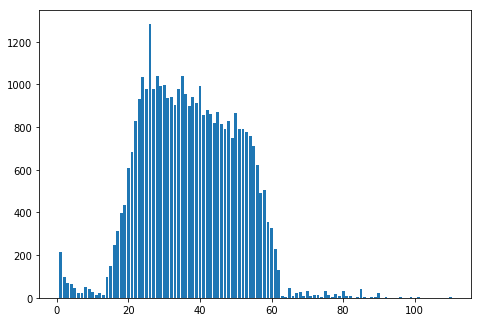

In [26]:
plot_sample(np.unique(np.array(y_test), return_counts=True))

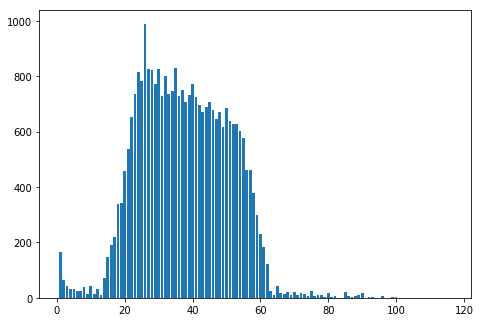

In [27]:
plot_sample(np.unique(np.array(y_valid), return_counts=True))

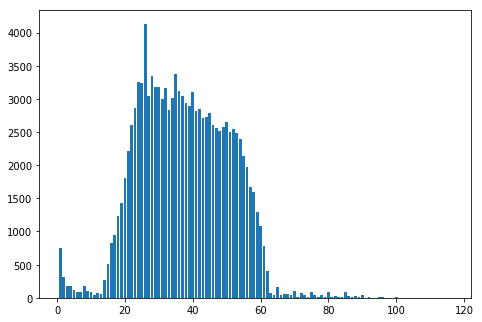

In [28]:
plot_sample(np.unique(np.array(y_train), return_counts=True))

In [53]:
big_arr = [*y_test, *y_train, *y_valid]
samples = np.unique(np.array(big_arr), return_counts=True)
total_count = len(big_arr)
cums = np.cumsum(samples[1],axis=0)
percentages = np.round(samples[1] / total_count,4) * 100
cums_perc = np.cumsum(percentages,axis=0)



In [54]:

stk = np.column_stack((samples[0], samples[1], percentages, cums, cums_perc))

# Save as csv
np.savetxt("all_count.csv", stk, fmt="%s", delimiter=",", comments="", header="Age,Count,Perc,accCount,accPerc")

In [58]:
csv= pandas.read_csv("./ss.csv", dtype=str)

In [80]:
pandas.Series.from_csv("./age_class_mapping.csv", header=0).to_dict()

{1: 1,
 2: 3,
 3: 3,
 4: 3,
 5: 7,
 6: 7,
 7: 7,
 8: 7,
 9: 7,
 10: 12,
 11: 12,
 12: 12,
 13: 12,
 14: 12,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 56: 56,
 57: 57,
 58: 58,
 59: 59,
 60: 60,
 61: 61,
 62: 65,
 63: 65,
 64: 65,
 65: 65,
 66: 70,
 67: 70,
 68: 70,
 69: 70,
 70: 70,
 71: 70,
 72: 70,
 73: 70,
 74: 70,
 75: 80,
 76: 80,
 77: 80,
 78: 80,
 79: 80,
 80: 80,
 81: 80,
 82: 80,
 83: 80,
 84: 80,
 85: 90,
 86: 90,
 87: 90,
 88: 90,
 89: 90,
 90: 90,
 91: 90,
 92: 90,
 93: 90,
 94: 90,
 95: 90,
 96: 90,
 97: 90,
 98: 90,
 99: 90,
 100: 90,
 101: 90,
 102: 90,
 103: 90,
 104: 90,
 105: 90,
 106: 90,
 107: 90,
 108: 90,
 109: 90,
 110: 90,
 111: 90,
 112: 9

In [72]:
pc = np.round(np.array(csv["Count"]).astype(int) / total_count * 100, 2)

In [73]:
np.savetxt("all_tmp.csv", pc, fmt="%s", delimiter=",", comments="", header="PC")